Matplotlib is building the font cache; this may take a moment.


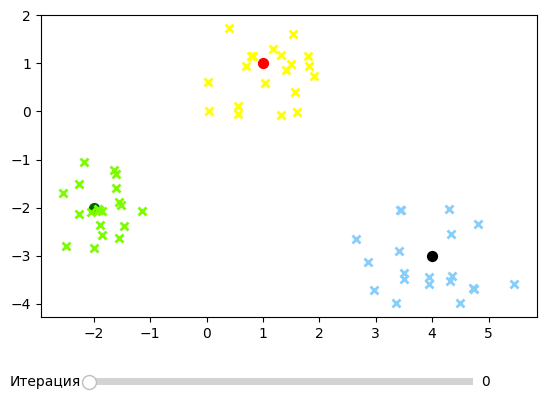

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import random

clusterCenters = [[1.0, 1.0], [-2.0, -2.0], [4.0, -3.0]]
radii = [1.5, 1.0, 2.0]
n_points = 20

# Проверка пересечения окружностей
for i in range(len(clusterCenters)):
    for j in range(i + 1, len(clusterCenters)):
        xi, yi = clusterCenters[i]
        xj, yj = clusterCenters[j]
        distance = np.sqrt((xi - xj)**2 + (yi - yj)**2)
        if distance < (radii[i] + radii[j]):
            print(f"Ошибка: Окружности {i+1} и {j+1} пересекаются!")
            exit()

# Генерация точек
points = []
for (x_center, y_center), r in zip(clusterCenters, radii):
    for _ in range(n_points):
        angle = np.random.uniform(0, 2 * np.pi)
        radius = np.random.uniform(0, r)
        x = x_center + radius * np.cos(angle)
        y = y_center + radius * np.sin(angle)
        points.append([x, y])
points = np.array(points)
xy = points.tolist()
random.shuffle(xy)


history = {'x_centers': [], 'y_centers': [], 'labels': [], 'x_klaster': [], 'y_klaster': []}

x = [p[0] for p in xy]
y = [p[1] for p in xy]
x_center = [c[0] for c in clusterCenters]
y_center = [c[1] for c in clusterCenters]

# Сохраняем начальные центры
history['x_centers'].append(x_center.copy())
history['y_centers'].append(y_center.copy())
history['labels'].append([0]*len(xy))  # Начальные метки

while True:
    # Вычисление расстояний
    distance_1 = [(x_center[0]-x[i])**2 + (y_center[0]-y[i])**2 for i in range(len(xy))]
    distance_2 = [(x_center[1]-x[i])**2 + (y_center[1]-y[i])**2 for i in range(len(xy))]
    distance_3 = [(x_center[2]-x[i])**2 + (y_center[2]-y[i])**2 for i in range(len(xy))]
    
    # Назначение меток
    labels = []
    for i in range(len(xy)):
        d1, d2, d3 = distance_1[i], distance_2[i], distance_3[i]
        if d1 <= d2 and d1 <= d3:
            labels.append(0)
        elif d2 <= d1 and d2 <= d3:
            labels.append(1)
        else:
            labels.append(2)
    
    # Разделение точек по кластерам
    klaster = [[], [], []]
    for i in range(len(xy)):
        klaster[labels[i]].append(xy[i])
    
    x_klaster = [[], [], []]
    y_klaster = [[], [], []]
    for i in range(3):
        for point in klaster[i]:
            x_klaster[i].append(point[0])
            y_klaster[i].append(point[1])
    
    # Сохраняем текущее состояние
    history['labels'].append(labels.copy())
    history['x_klaster'].append(x_klaster.copy())
    history['y_klaster'].append(y_klaster.copy())
    
    # Вычисление новых центров
    new_x_center = []
    new_y_center = []
    for i in range(3):
        if klaster[i]:
            new_x_center.append(sum(x_klaster[i])/len(x_klaster[i]))
            new_y_center.append(sum(y_klaster[i])/len(y_klaster[i]))
        else:
            new_x_center.append(x_center[i])
            new_y_center.append(y_center[i])
    
    # Сохраняем новые центры
    history['x_centers'].append(new_x_center.copy())
    history['y_centers'].append(new_y_center.copy())
    
    # Проверка условия остановки
    if labels == history['labels'][-2] if len(history['labels']) > 1 else False:
        break
    
    x_center, y_center = new_x_center, new_y_center

# Создание графика с ползунком 
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)

# Начальный график (нулевая итерация)
plots = []
colors = ['yellow', 'lawngreen', 'lightskyblue']
for i in range(3):
    if history['x_klaster'][0][i]:  # Проверка на пустые кластеры
        plot, = ax.plot(history['x_klaster'][0][i], history['y_klaster'][0][i], 
                       'x', markeredgewidth=2, c=colors[i])
        plots.append(plot)
    else:
        plots.append(None)

# Центры 
center_colors = ['r', 'darkgreen', 'black']
centers_plots = []
for i in range(3):
    cp = ax.scatter(history['x_centers'][0][i], history['y_centers'][0][i], 
                   c=center_colors[i], s=50)
    centers_plots.append(cp)

# Создание ползунка
ax_slider = plt.axes([0.2, 0.1, 0.6, 0.03])
slider = Slider(ax_slider, 'Итерация', 0, len(history['labels'])-1, 
               valinit=0, valstep=1)

# Функция обновления графика
def update(val):
    iteration = int(slider.val)
    
    # Обновление точек кластеров
    for i in range(3):
        if plots[i] is not None:
            if iteration < len(history['x_klaster']) and i < len(history['x_klaster'][iteration]):
                plots[i].set_data(history['x_klaster'][iteration][i], 
                                history['y_klaster'][iteration][i])
            else:
                plots[i].set_data([], [])
    
    # Обновление центров
    for i in range(3):
        if iteration < len(history['x_centers']):
            centers_plots[i].set_offsets([history['x_centers'][iteration][i], history['y_centers'][iteration][i]])
    
    fig.canvas.draw_idle()

slider.on_changed(update)
plt.show()